<a href="https://colab.research.google.com/github/caguilarglz/MasterIAGenerativa/blob/main/Proyecto_%22Universidad_Pontificia_de_Comillas_ICADE%22_RAG_web_%26_PDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
<h1 align="center"><strong>Pregunta A Tus Páginas Web Utilizando Mistral-7b y LangChain</strong></h1>

---

### **Introducción**

Vamo a crear un Marketing Manager que responda preguntas referentes a la Universidad Pontificia de Comillas. Haremos esto utilizando el LLM de open source Mistral7b, el cual no dispone de ta especifica sobre esta univerisdad ya quew no ha sido pre-entrenado con data referente a esta institución. Es por eso que llevaremos a cabo un RAG utilizando paginas web y PDFs.

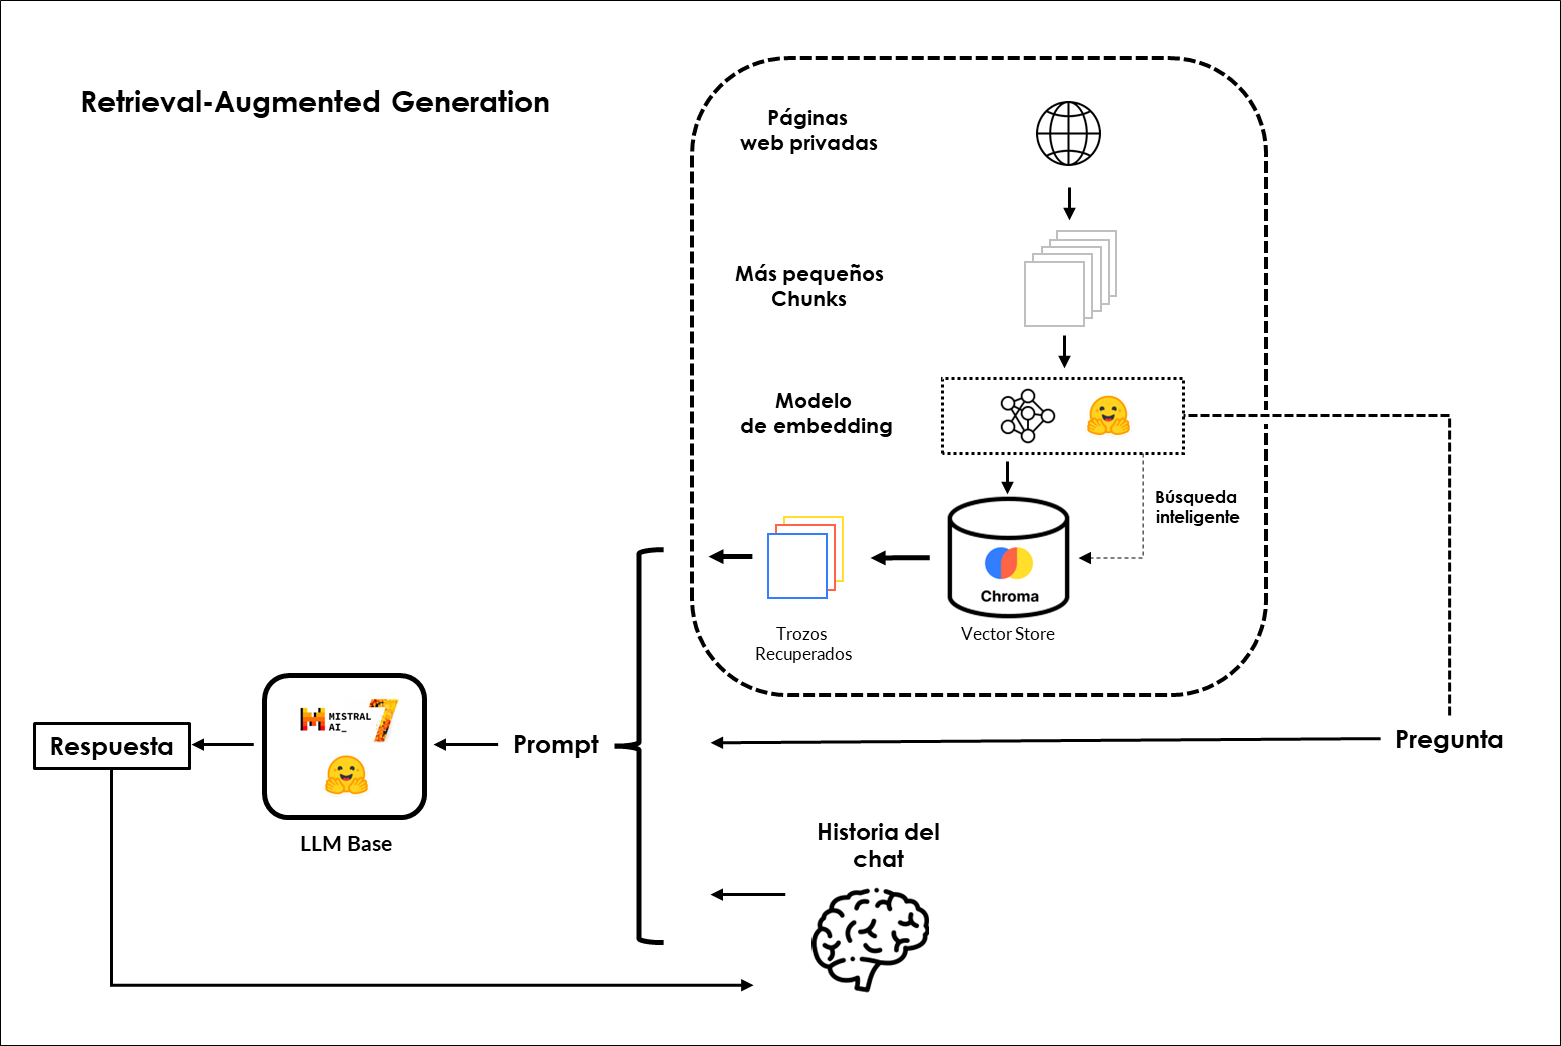

#### Instalaciones

Estas líneas de código están instalando varias **librerías Python** y **paquetes** usando el gestor de paquetes **pip**, jutno con la bandera **--quiet** la cual se usa para reducir la cantidad de salida mostrada durante el proceso de instalación, haciéndolo menos ruidoso.

In [1]:
!pip install gradio --quiet
!pip install xformer --quiet
!pip install chromadb --quiet
!pip install langchain --quiet
!pip install accelerate --quiet
!pip install transformers --quiet
!pip install bitsandbytes --quiet
!pip install unstructured --quiet
!pip install sentence-transformers --quiet
!pip install pypdf --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.0/284.0 kB 2.2 MB/s eta 0:00:00


#### Importaciones



Importamos principalmente **PyTorch** para capacidades de aprendizaje profundo y **Gradio** para construir interfaces interactivas de modelos ML. Además, importamos módulos de la biblioteca **langchain**, que incluye plantillas para crear prompts, varios modelos de cadena para la comprensión y generación de lenguaje, text embeddings y cargadores de documentos. Nuestro código también integra la potente biblioteca **Transformers**, que permite el uso sin problemas de **los modelos de última generación de Hugging Face** para una amplia gama de aplicaciones de PLN.

In [2]:
import torch
import gradio as gr

from textwrap import fill
from IPython.display import Markdown, display

from langchain.prompts.chat import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    SystemMessagePromptTemplate,
    )

from langchain import PromptTemplate
from langchain import HuggingFacePipeline

from langchain.vectorstores import Chroma
from langchain.schema import AIMessage, HumanMessage
from langchain.memory import ConversationBufferMemory
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import UnstructuredMarkdownLoader, UnstructuredURLLoader
from langchain.chains import LLMChain, SimpleSequentialChain, RetrievalQA, ConversationalRetrievalChain

from transformers import BitsAndBytesConfig, AutoModelForCausalLM, AutoTokenizer, GenerationConfig, pipeline

import warnings
warnings.filterwarnings('ignore')




from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.llms import HuggingFaceHub
from langchain.vectorstores import Chroma
from langchain.chains import ConversationalRetrievalChain

#### LLM Base

Vamos a utilizar **Mistral-7b** desarrollado por **Mistral AI** este LLM de código abierto supera a LLaMA-2 en muchas pruebas comparativas, como ilustra la siguiente imagen extraída de su documento:

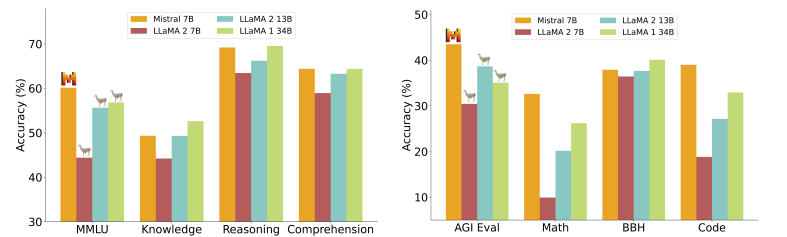

El siguiente fragmento de código se configura un **proceso de generación de texto** utilizando un LLM base, **Mistral-7b**, instruye al modelo de lenguaje preentrenado, lo configura con ajustes de **cuantización**, **tokenización** y **parámetros de generación**, y crea un proceso que puede utilizarse para generar texto basado en el LLM **Mistral-7b** y las configuraciones. Vamos a desglosar lo que sucede:

* **`quantization_config = BitsAndBytesConfig(...)`**: Aquí se define una configuración de **cuantización** utilizando **BitsAndBytesConfig**. La cuantificación es una técnica utilizada para reducir los requisitos de memoria y computación de los modelos de aprendizaje profundo, normalmente mediante el uso de **menos bits**, **4 bits** en nuestro caso para representar los parámetros del modelo.

* **`tokenizer = AutoTokenizer.from_pretrained(...)`**: Esta línea inicializa un tokenizador para el modelo **Mistral-7b**, permitiéndole preprocesar datos de texto para introducirlos en el modelo.

* **`model = AutoModelForCausalLM.from_pretrained(...)`**: Esto inicializa el modelo de lenguaje **Mistral-7b** pre-entrenado para el modelado causal del lenguaje. El modelo se configura con varios parámetros, incluyendo la **configuración** de **cuantización**, que se estableció anteriormente.

* **`generation_config = GenerationConfig.from_pretrained(...)`**: Se crea una **configuración de generación** para el modelo, especificando varios parámetros relacionados con la generación, como el **número máximo de tokens**, la **temperature** para el **sampling**, el **top-p sampling** y la **repetition penalty**.

* **`pipeline = pipeline(...)`**: Por último, se crea una línea de generación de texto utilizando la función **pipeline**. Esta tubería se configura para la generación de texto, y toma el modelo pre-entrenado, el tokenizer, y la configuración de generación como entradas. Está configurado para devolver salidas de texto completo.


In [3]:
MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.1"

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME, torch_dtype=torch.float16,
    trust_remote_code=True,
    device_map="auto",
    quantization_config=quantization_config
)

generation_config = GenerationConfig.from_pretrained(MODEL_NAME)
generation_config.max_new_tokens = 1024
generation_config.temperature = 0.0001
generation_config.top_p = 0.95
generation_config.do_sample = True
generation_config.repetition_penalty = 1.15

pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    return_full_text=True,
    generation_config=generation_config,
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

**HuggingFacePipeline** es un objeto que permite ejecutar modelos Hugging Face localmente. Se utiliza para acceder y utilizar una amplia gama de modelos ML pre-entrenados alojados en el Hugging Face Model Hub. En nuestro caso, la utilizaremos dentro de nuestro entorno LangChain para interactuar con los modelos de Hugging Face como **local wrapper**. Sin embargo, cuando se trabaja con HuggingFacePipeline, se recomienda la instalación de **xformer** para una implementación de atención más eficiente en memoria. Por eso lo hemos instalado más arriba.

In [4]:
llm = HuggingFacePipeline(
    pipeline=pipeline,
    )

#### ...pero el modelo no dispone de información especifica sore esta universidad, por lo que las respuestas que ofrece no son correctas


In [7]:
query = "What is icade?"
result = llm(
    query
)

display(Markdown(f"<b>{query}</b>"))
display(Markdown(f"<p>{result}</p>"))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<b>What is icade?</b>

<p>
A: Q: ICADE stands for International Council of Automotive Dealers Education. It is a non-profit organization that provides training and education to automotive dealership professionals in various areas such as sales, marketing, finance, and customer service. The goal of ICADE is to help dealerships improve their operations and increase profitability by providing high-quality training programs and resources.</p>

In [8]:
query = "What studies are taught at icade?"
result = llm(
    query
)

display(Markdown(f"<b>{query}</b>"))
display(Markdown(f"<p>{result}</p>"))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<b>What studies are taught at icade?</b>

<p>
A: Computer science, information technology and digital arts.</p>

Estas no son respuestas esperadas. Esto se debe a que Mistral-7b LLM nunca ha visto ninguna información especifica sobre esta institución en su preentrenamiento. Sin embargo, vamos a hacer RAG para nutrir al LLM de información especifica:

#### 1. Embeddings

Después de establecer nuestro LLM base, es hora de establecer un **modelo de embedding**. Cada documento debe convertirse en un **vector de embedding** para permitir la búsqueda semántica utilizando la consulta del usuario, que también debe incrustarse. Para ello, utilizaremos el modelo de incrustación **GTE** entrenado por **Alibaba DAMO Academy** y alojado en Hugging Face. Cabe destacar que este modelo es **gratuito** y **potente**. Para llevar a cabo nuestra tarea, utilizaremos la clase **HuggingFaceEmbeddings**, un pipeline wrapper local para interactuar con el modelo GTE alojado en Hugging Face Hub.

In [9]:
embeddings = HuggingFaceEmbeddings(
    model_name="thenlper/gte-large",
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},
)

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/67.9k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]



```
# This is formatted as code
```

#### 2. Prompt Template

Vamos a hacer que el modelo se comporte según nuestras preferencias, controlando la salida del modelo sin especificarlo todo explícitamente en la consulta o prompt del usuario. Esto mediante **prompt templates**, que son recetas predefinidas para generar avisos para modelos lingüísticos. En otros contextos, se puede dar una identidad a un LLM mediante un **Mensaje de sistema**.

Utilizamos **PromptTemplate** para crear un prompt estructurado. Una plantilla puede incluir **instrucciones**, **n-shot ejemplos** y **contexto específico** y preguntas adecuadas para una tarea en particular.

In [4]:
template = """
[INST] <>
Act as a Machine Learning engineer who is teaching high school students.
<>

{text} [/INST]
"""

prompt = PromptTemplate(
    input_variables=["text"],
    template=template,
)

#### 3. Carga de datos (páginas web)

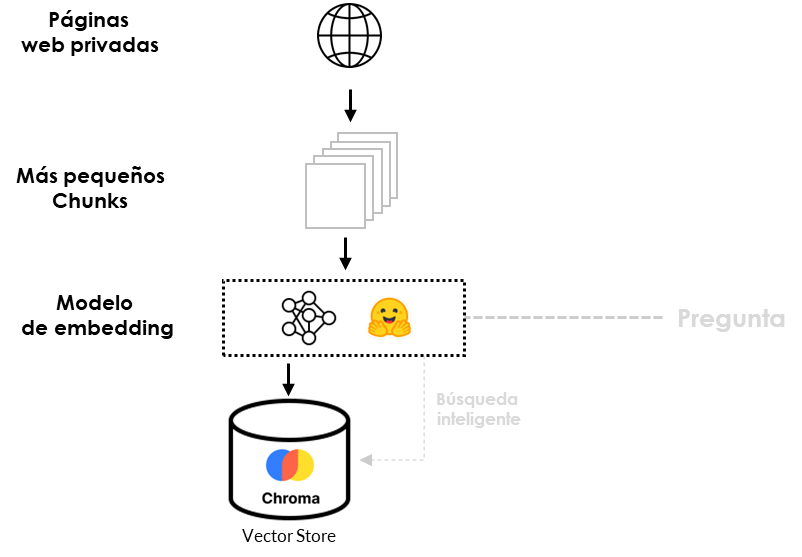

In [5]:
urls = [
    "https://www.comillas.edu/historia-y-compania-de-jesus/",
    "https://www.comillas.edu/icade/",
    "https://www.comillas.edu/icai/",
    "https://www.comillas.edu/cihs/",
    "https://www.comillas.edu/grados/?area=Empresarial",
    "https://www.comillas.edu/grados/?area=Jur%C3%ADdica",
    "https://www.comillas.edu/grados/?area=Relaciones%20Internacionales",
    "https://www.comillas.edu/grados/?area=Ingenier%C3%ADa",
    "https://www.comillas.edu/grados/?area=Traducci%C3%B3n%20y%20comunicaci%C3%B3n"
]

loader = UnstructuredURLLoader(urls=urls)
documents = loader.load()

len(documents)
# output: 2

9

Ahora tenemos nueve documentos de gran tamaño repletos de datos, y eso podría superar la **ventana de contexto** de nuestro Mistral-7b LLM. Para mantener todo bajo control, vamos a dividirlos en **21 documentos más pequeños** o **chunks**, cada uno con un límite de **1024 tokens**. Además, hemos fijado el tamaño de **chunk overlap** en **64** para garantizar que haya cierta continuidad de contexto entre trozos consecutivos. Permanece atento al próximo paso en la ingesta de esta aventura de datos.

In [14]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1024, chunk_overlap=64)
texts_chunks = text_splitter.split_documents(documents)

len(texts_chunks)
# output: 21

69

In [ ]:
# Load the pdf file and split it into smaller chunks
loader = PyPDFLoader('report.pdf')
documents = loader.load()

# Split the documents into smaller chunks
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
texts = text_splitter.split_documents(documents)

#### Ingesta de datos

Una vez que tenemos nuestros trozos de datos manejables, el siguiente paso es incrustarlos e indexarlos en **Chromdb**, nuestro **vector store**.

In [15]:
db = Chroma.from_documents(texts_chunks, embeddings, persist_directory="db")

In [19]:
def data_ingestion_indexing(directory_path):
  # Carga los datos de la ruta de directorio especificada
  documents = SimpleDirectoryReader(directory_path).load_data()

  # Al crear el índice por primera vez
  index = GPTVectorStoreIndex.from_documents(
      documents, service_context=create_service_context()
  )

  # Manten el índice en el disco, carpeta "storage" por defecto
  index.storage_context.persist()

  return index


Una vez indexados nuestros datos, en el script que aparece a continuación, ajustamos nuestra plantilla de consulta para que se adapte a nuestras necesidades y damos a nuestro modelo de RAG la personalidad de un experto en gestión de marketing.

Además, para combinar nuestro LLM con las capacidades de recuperación de la base de datos vectorial, utilizamos el componente crucial de encadenamiento **RetrievalQA** con **`k=2`**. Esta configuración garantiza que el recuperador produzca dos fragmentos relevantes, que el LLM utiliza para formular la respuesta cuando se presenta una pregunta.

In [16]:
template = """
[INST] <>
Act as an Universidad de Comillas marketing manager expert. Use the following information to answer the question at the end.
<>

{context}

{question} [/INST]
"""

prompt = PromptTemplate(template=template, input_variables=["context", "question"])

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=db.as_retriever(search_kwargs={"k": 2}),
    return_source_documents=True,
    chain_type_kwargs={"prompt": prompt},
)

#### Querying

Nuestro sistema GAR está listo para responder a preguntas:

In [ ]:
query = "What is icade?"
result_ = qa_chain(
    query
)
result = result_["result"].strip()


display(Markdown(f"<b>{query}</b>"))
display(Markdown(f"<p>{result}</p>"))

In [ ]:
query = "What studies are taught at icade?"
result_ = qa_chain(
    query
)
result = result_["result"].strip()


display(Markdown(f"<b>{query}</b>"))
display(Markdown(f"<p>{result}</p>"))

#### Follow-Up Q/A

En el mundo real, el chat de seguimiento es útil, especialmente con los asistentes conversacionales de IA. Permite a los usuarios entablar conversaciones naturales con el modelo al mismo tiempo que conserva el historial de chat en el contexto del modelo. Esto significa que los usuarios pueden referirse implícitamente a algo de lo que han hablado en mensajes de chat anteriores o sacar a colación temas sobre los que han charlado en el pasado. Es como charlar amistosamente con un amigo de la inteligencia artificial que te recuerda. 🗨️💬

Para que esto suceda, primero hacemos algunos ajustes en la plantilla de avisos. A continuación, utilizamos **`ConversationBufferMemory`** para almacenar la conversación en memoria y recuperar los mensajes más tarde. Por último, empleamos el componente de encadenamiento **`ConversationalRetrievalChain`** para combinar nuestro LLM, Mistral-7b, con la base de datos vectorial y el historial de chat. Todo ello, para mejorar la experiencia de conversación del usuario.

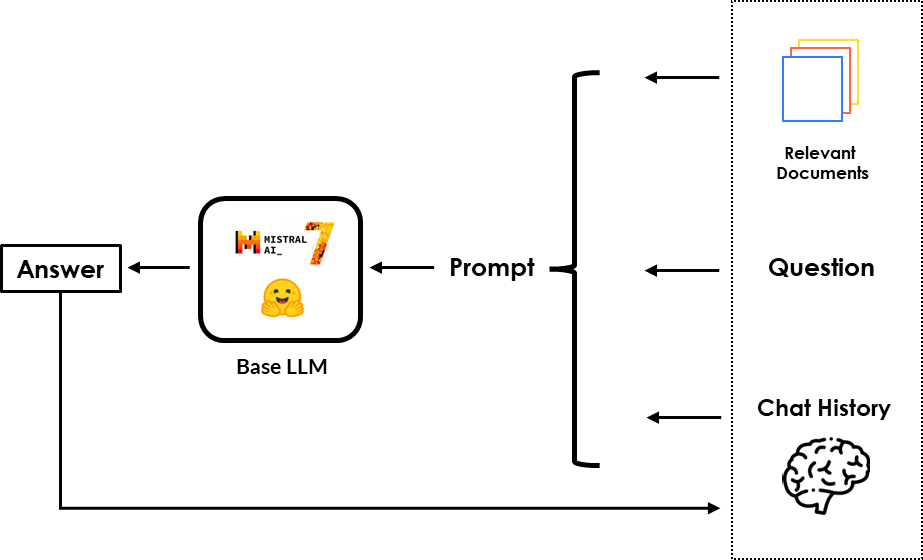

In [ ]:
custom_template = """You are an Universidad de Comillas Marketing Manager AI Assistant. Given the
following conversation and a follow up question, rephrase the follow up question
to be a standalone question. At the end of standalone question add this
'Answer the question in English language.' If you do not know the answer reply with 'I am sorry, I dont have enough information'.
Chat History:
{chat_history}
Follow Up Input: {question}
Standalone question:
"""

CUSTOM_QUESTION_PROMPT = PromptTemplate.from_template(custom_template)

memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

qa_chain = ConversationalRetrievalChain.from_llm(
    llm=llm,
    retriever=db.as_retriever(search_kwargs={"k": 2}),
    memory=memory,
    condense_question_prompt=CUSTOM_QUESTION_PROMPT,
)

In [ ]:
query = "Who you are?"
result_ = qa_chain({"question": query})
result = result_["answer"].strip()

display(Markdown(f"<b>{query}</b>"))
display(Markdown(f"<p>{result}</p>"))

In [ ]:
query = "What is icade?"

result_ = qa_chain({"question": query})
result = result_["answer"].strip()

display(Markdown(f"<b>{query}</b>"))
display(Markdown(f"<p>{result}</p>"))

### **Gradio Chat UI**

Usamos **Gradio** para **mostrar** el modelo de RAG en una interfaz web fácil de usar a la que cualquiera puede acceder desde cualquier lugar. Funciona así: creamos una función llamada **`querying()`**. Toma **`query`** como entrada principal, junto con un argumento falso llamado **`history`** para resolver un problema menor. Cuando se activa esta función, devuelve la respuesta generada por nuestro modelo Mistral-7b.

In [ ]:
def querying(query, history):
  memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

  qa_chain = ConversationalRetrievalChain.from_llm(
      llm=llm,
      retriever=db.as_retriever(search_kwargs={"k": 2}),
      memory=memory,
      condense_question_prompt=CUSTOM_QUESTION_PROMPT,
  )

  result = qa_chain({"question": query})
  return result["answer"].strip()

In [ ]:
iface = gr.ChatInterface(
    fn = querying,
    chatbot=gr.Chatbot(height=600),
    textbox=gr.Textbox(placeholder="What is GenAI Ecosystem?", container=False, scale=7),
    title="HiberusBot",
    theme="soft",
    examples=["Why Hiberus has created GenAI Ecosystem?",
              "What is GenAI Ecosystem?"],

    cache_examples=True,
    retry_btn="Repetir",
    undo_btn="Deshacer",
    clear_btn="Borrar",
    submit_btn="Enviar"

    )

iface.launch(share=True)

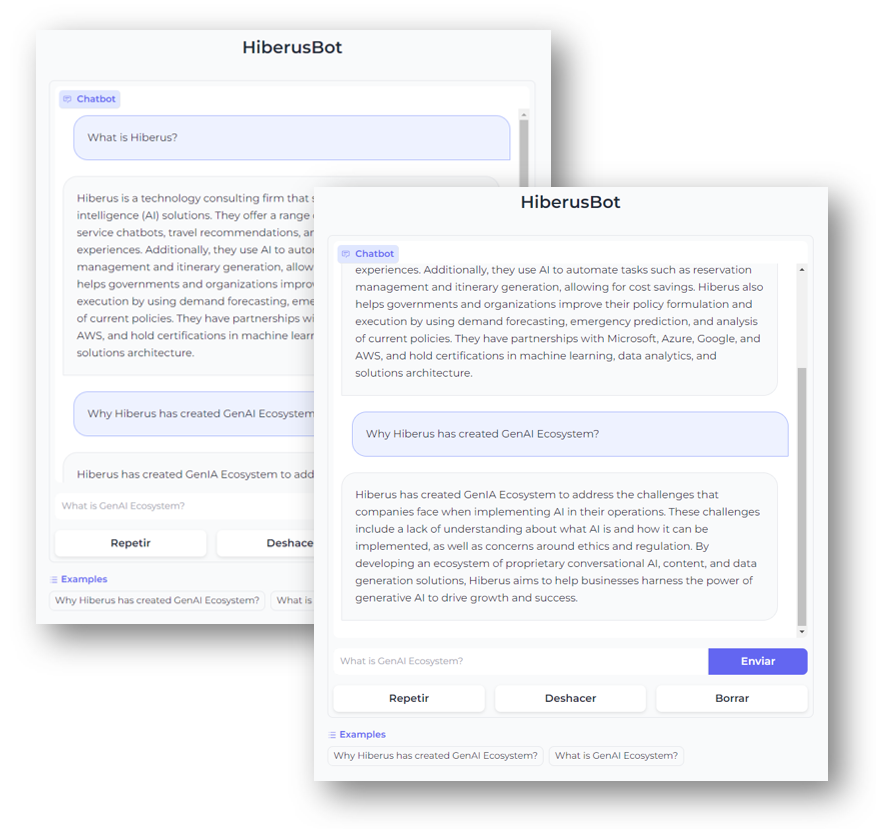

___